## Code alongs - overfitting and underfitting
### Simulate data
$y=a_0+a_1x+a_2x^2+\epsilon$

where $\epsilon\sim\mathcal{N}(0,1)$ (the error is standard normal distributed)

In [3]:
import numpy as np
import matplotlib.pyplot as plt

samples = 100
X = np.random.uniform(-3,3, (samples, 1))
X.shape 

(100, 1)

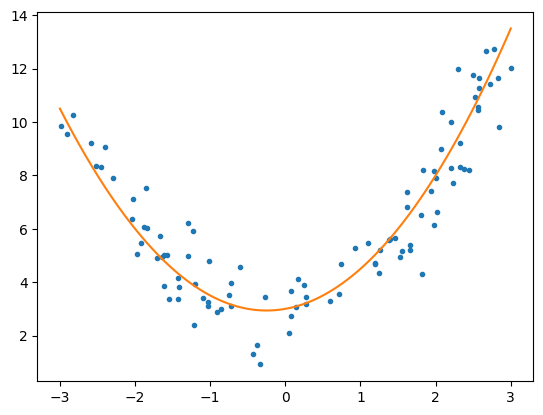

In [4]:
# a0 = 3, a1 = 0.5, a2 = 1
f = lambda x: x**2 + 0.5*x +3

# y = a0 + a1x + a2x^2 + epsilon
y = f(X) + np.random.randn(samples,1)

# linspace gives equally spaced numbers between low and high
# between -3 and 3 we get 100 equally spaced numbers
x = np.linspace(-3,3,samples)

plt.plot(X,y, '.')
plt.plot(x,f(x))


<Axes: title={'center': '$y= x^2+0.5x+3+\\epsilon$'}>

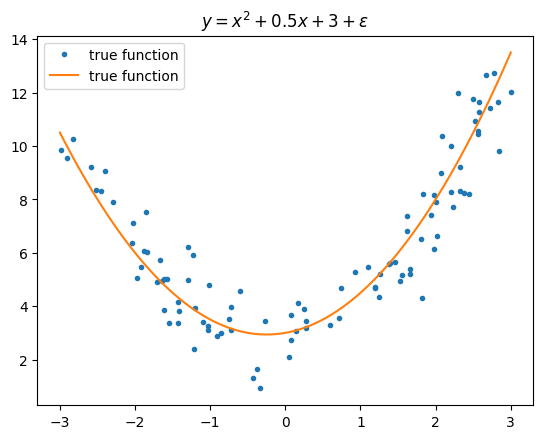

In [7]:
def draw_data():
    fig, ax = plt.subplots()
    ax.plot(X,y, '.',label="true function")
    ax.plot(x, f(x),label="true function")
    ax.set(title= r"$y= x^2+0.5x+3+\epsilon$")
    ax.legend()

    return ax

draw_data()